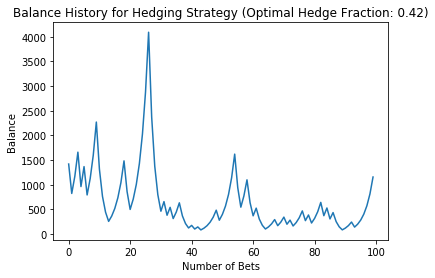

Hedging strategy has won 61 times and lost 39 times in 100 bets.


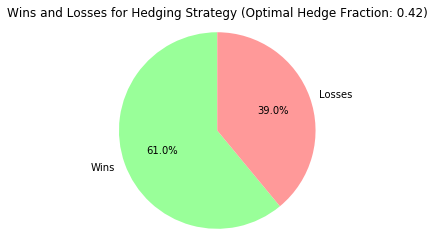

In [19]:
import random
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp

class HedgingStrategy:
    def __init__(self, hedge_fraction, win_probability, num_bets, budget):
        self.hedge_fraction = hedge_fraction
        self.win_probability = win_probability
        self.num_bets = num_bets
        self.budget = budget

    def simulate_betting_strategy(self, return_history=False, return_stats=False):
        balance = self.budget
        wins = 0
        losses = 0
        balance_history = []

        for _ in range(self.num_bets):
            if balance <= 0:
                break

            bet_amount = balance * self.hedge_fraction
            won_bet = random.random() < self.win_probability

            if won_bet:
                balance += bet_amount
                wins += 1
            else:
                balance -= bet_amount
                losses += 1

            balance_history.append(balance)

        result = (balance,)
        if return_history:
            result += (balance_history,)
        if return_stats:
            result += (wins, losses)

        return result if len(result) > 1 else result[0]

    def _run_trials(self, hedge_fraction, trials_per_combination):
        total_utility = 0
        total_wins = 0
        total_losses = 0

        for _ in range(trials_per_combination):
            balance, wins, losses = self.simulate_betting_strategy(return_history=False, return_stats=True)
            total_utility += np.log(balance)
            total_wins += wins
            total_losses += losses

        avg_utility = total_utility / trials_per_combination
        return hedge_fraction, avg_utility, total_wins, total_losses

    def optimize_hedge_fraction(self, trials_per_combination, min_fraction, max_fraction, step_size, min_win_percentage, pool):
        optimal_fraction = 0
        best_avg_utility = -float('inf')
        least_losses = float('inf')
        results = []

        trials_args = [(hedge_fraction, trials_per_combination) for hedge_fraction in np.arange(min_fraction, max_fraction + step_size, step_size)]
        results = pool.starmap(self._run_trials, trials_args)

        avg_utilities = []

        for hedge_fraction, avg_utility, wins, losses in results:
            avg_utilities.append(avg_utility)

            total_bets = wins + losses
            win_percentage = wins / total_bets if total_bets > 0 else 0

            if win_percentage >= min_win_percentage:
                if losses < least_losses:
                    least_losses = losses
                    best_avg_utility = avg_utility
                    optimal_fraction = hedge_fraction
                elif losses == least_losses and avg_utility > best_avg_utility:
                    best_avg_utility = avg_utility
                    optimal_fraction = hedge_fraction

        return optimal_fraction, best_avg_utility, avg_utilities

trials_per_combination = 100
min_fraction = 0.01
max_fraction = 0.8
step_size = 0.01
min_win_percentage = 0.5

budget = 1000
win_probability = 0.6
num_bets = 100

# Create a temporary betting_strategy instance to optimize the hedge_fraction
temp_betting_strategy = HedgingStrategy(0, win_probability, num_bets, budget)

# Create a multiprocessing pool
pool = mp.Pool(mp.cpu_count())

# Call the optimize_hedge_fraction method and obtain the optimal_fraction
optimal_fraction, best_avg_utility, avg_utilities = temp_betting_strategy.optimize_hedge_fraction(trials_per_combination, min_fraction, max_fraction, step_size, min_win_percentage, pool)

# Close the multiprocessing pool
pool.close()

# Initialize the betting_strategy instance with the optimal_fraction
betting_strategy = HedgingStrategy(optimal_fraction, win_probability, num_bets, budget)

# Plot the balance history for the hedging strategy
balance, balance_history, wins, losses = betting_strategy.simulate_betting_strategy(return_history=True, return_stats=True)
plt.plot(balance_history)
plt.xlabel('Number of Bets')
plt.ylabel('Balance')
plt.title(f'Balance History for Hedging Strategy (Optimal Hedge Fraction: {optimal_fraction:.2f})')
plt.show()

print(f"Hedging strategy has won {wins} times and lost {losses} times in {num_bets} bets.")

# Pie chart for the hedging strategy's wins and losses
labels = ['Wins', 'Losses']
sizes = [wins, losses]
colors = ['#99ff99', '#ff9999']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title(f"Wins and Losses for Hedging Strategy (Optimal Hedge Fraction: {optimal_fraction:.2f})")
plt.show()
